In [ ]:
# ONLY FOR GOOGLE COLAB!
from google.colab import drive

drive.mount("/gdrive")
!ln -s "/gdrive/MyDrive/Colab Notebooks/ericsson/data" "/content"

In [ ]:
# ONLY FOR GOOGLE COLAB!
# drive.flush_and_unmount()
# !rm "./ericsson"
# !rm "./data"

In [ ]:
# ONLY FOR GOOGLE COLAB!
!pip install pymoo

In [1]:
import gzip
import os
import re

import pandas as pd


def read_gzip_file(file_path):
    with gzip.open(file_path) as f:
        data1 = pd.read_csv(f, sep=";", skiprows=[0, 1], header=None)
    return data1


def read_all_data(path):
    dataFrames = []
    # iterate through all files
    for file in os.listdir(path):
        if file.endswith(".gzip"):
            file_path = f"{path}/{file}"
            # call read text file function
            dataFrames.append(read_gzip_file(file_path))
    data = pd.concat(dataFrames, ignore_index=True)
    data.columns = ["time", "latitude", "longitude", "nw data", "accuracy"]
    return data


def _get_param(val: str, name: str):
    m = re.match(f"^.* {name}=([^ ]+).*$", val)
    if m:
        return m.group(1)
    return None


def get_param(cell, name: str):
    if type(cell) is list:
        return [get_param(c, name) for c in cell]
    elif type(cell) is dict:
        param = _get_param(cell["signal"], name)
        if param:
            return param
        return _get_param(cell["identity"], name)
    return None


class CellInfo:
    def __init__(self, s: str):
        all_info = s.split("!")
        self.num_cells = int(all_info[0])
        sig_id = all_info[1:]
        self._info = [
            {
                "type": self.__get_type(sig_id[i + 1]),
                "signal": sig_id[i],
                "identity": sig_id[i + 1],
            }
            for i in range(0, self.num_cells, 2)
        ]

    def __str__(self):
        wcdma_len = len(self.wcdma())
        lte_len = len(self.lte())
        return f"CellInfo: n={self.num_cells} wcdma={wcdma_len} lte={lte_len}"

    def __repr__(self):
        return str(self)

    def cell_types(self):
        return set([cell["type"] for cell in self._info])

    def all(self):
        return self._info

    def wcdma(self):
        return [i for i in self._info if i["type"] == "Wcdma"]

    def lte(self):
        return [i for i in self._info if i["type"] == "Lte"]

    def get_by_pci(self, pci: str):
        return [cell for cell in self.lte() if get_param(cell, "mPci") == pci]

    def get_by_mcc_mnc(self, mcc: str, mnc: str):
        return [
            cell
            for cell in self.all()
            if get_param(cell, "mMcc") == mcc and get_param(cell, "mMnc") == mnc
        ]

    def get_attached(self):
        return [cell for cell in self.all() if get_param(cell, "mMnc") != "null"]

    def get_attached_lte(self):
        return [cell for cell in self.lte() if get_param(cell, "mMnc") != "null"]

    def get_attached_wcdma(self):
        return [cell for cell in self.wcdma() if get_param(cell, "mMnc") != "null"]

    def __get_type(self, cell_id_str: str):
        return cell_id_str.split(":")[0][len("CellIdentity") :]


def explode_nw_data(df: pd.DataFrame, col_name="nw data"):
    exploded_df = df.copy()
    exploded_df[col_name] = df[col_name].apply(lambda txt: CellInfo(txt))
    return exploded_df


def rsrp_per_pci(df: pd.DataFrame, PCI: int, agg=min):
    pci_df = df[df["pci"].apply(lambda x: PCI in x)].copy()
    pci_df["rsrp"] = pci_df["nw data"].apply(
        lambda x: agg(
            [float(get_param(pcell, "rsrp")) for pcell in x.get_by_pci(str(PCI))]
        )
    )
    return pci_df


def _at_least_one(values, search):
    for v in values:
        if v in search:
            return True
    return False


def _join(list_of_lists):
    joined_list = []
    for l in list_of_lists:
        joined_list += l
    return joined_list


def rsrp_per_multiple_pci(df: pd.DataFrame, PCIs: list, agg=min):
    pci_df = df[df["pci"].apply(_at_least_one, args=(PCIs,))].copy()
    pci_df["rsrp"] = pci_df["nw data"].apply(
        lambda x: agg(
            [
                float(get_param(pcell, "rsrp"))
                for pcell in _join([x.get_by_pci(str(pci)) for pci in PCIs])
            ]
        )
    )
    return pci_df


def rsrp_per_plmn(df: pd.DataFrame, mcc: str, mnc: str, agg=min):
    plmn_df = df[df["plmn lte"].apply(lambda x: "-".join([mcc, mnc]) in x)].copy()
    plmn_df["rsrp"] = plmn_df["nw data"].apply(
        lambda x: agg(
            [float(get_param(pcell, "rsrp")) for pcell in x.get_by_mcc_mnc(mcc, mnc)]
        )
    )
    return plmn_df


def rscp_per_plmn(df: pd.DataFrame, mcc: str, mnc: str, agg=min):
    plmn_df = df[df["plmn wcdma"].apply(lambda x: "-".join([mcc, mnc]) in x)].copy()
    plmn_df["rscp"] = plmn_df["nw data"].apply(
        lambda x: agg(
            [
                float(get_param(pcell, "rscp"))
                for pcell in x.get_by_mcc_mnc(mcc, mnc)
                if get_param(pcell, "rscp") is not None
            ]
        )
    )
    return plmn_df


def get_plmn(cell: dict):
    mcc = get_param(cell, "mMcc")
    mnc = get_param(cell, "mMnc")
    return "-".join([mcc, mnc])


def expand_dataframe(df: pd.DataFrame):
    df["pci"] = df["nw data"].apply(
        lambda x: (
            [int(p) for p in get_param(x.get_attached_lte(), "mPci") if p is not None]
            + [int(p) for p in get_param(x.get_attached_lte(), "pci") if p is not None]
        )
    )

    df["plmn lte"] = df["nw data"].apply(
        lambda x: set([get_plmn(cell) for cell in x.get_attached_lte()])
    )
    df["plmn wcdma"] = df["nw data"].apply(
        lambda x: set([get_plmn(cell) for cell in x.get_attached_wcdma()])
    )
    return df


import logging as log
import pandas as pd


class MobileDataParser:
    def __init__(self, raw_data: pd.DataFrame) -> None:
        log.info("Created MobileDataParser, parsing raw data...")
        self.raw_data = self._prune_invalid_data(raw_data)
        self._measurement_points = self._parse_to_measurement_points(self.raw_data)

    def get_measurement_points(self) -> pd.DataFrame:
        return self._measurement_points

    def get_event_points(self, thresholds: dict[str, float] = {}) -> pd.DataFrame:
        # params to detect events
        rsrp_range = [-140, -44]
        rsrq_range = [-19.5, -3]
        offset_range = [-15, 15]

        RSRSP_TH: float = thresholds.get("rsrp", rsrp_range[0])
        RSRQ_TH: float = thresholds.get("rsrq", rsrq_range[0])
        OFFSET: float = thresholds.get("offset", offset_range[1])

        assert (
            rsrp_range[0] <= RSRSP_TH <= rsrp_range[1]
        ), f"rsrp threshold {RSRSP_TH} is out of range {rsrp_range}"
        assert (
            rsrq_range[0] <= RSRQ_TH <= rsrq_range[1]
        ), f"rsrq threshold {RSRQ_TH} is out of range {rsrq_range}"
        assert (
            offset_range[0] <= OFFSET <= offset_range[1]
        ), f"offset {OFFSET} is out of range {offset_range}"

        events_df = []
        size = self._measurement_points.shape[0]
        for i, row in self._measurement_points.iterrows():
            cells = row["lte"]
            if cells and 0 < i < size:
                # present cells - ta should be close to 0, ex. 0-10, mcc and mnc should exist
                scell = None
                for scell_index, cell_info in enumerate(cells):
                    if cell_info["identity"]["mMnc"] is not None:
                        scell = cell_info
                        break

                # previous cells
                prev_scell = None
                prev_cells = self._measurement_points.iloc[i - 1]["lte"]
                for cell_info in prev_cells:
                    if cell_info["identity"]["mMnc"] is not None:
                        prev_scell = cell_info
                        break

                assert scell is not None
                assert prev_scell is not None

                scell_rsrp = scell["signal"]["rsrp"]
                scell_rsrq = scell["signal"]["rsrq"]
                pscell_rsrp = prev_scell["signal"]["rsrp"]
                pscell_rsrq = prev_scell["signal"]["rsrq"]

                def is_a1_event():
                    return ((scell_rsrp > RSRSP_TH) and (pscell_rsrp < RSRSP_TH)) or (
                        (scell_rsrq > RSRQ_TH) and (pscell_rsrq < RSRQ_TH)
                    )

                def is_a2_event():
                    return ((scell_rsrp < RSRSP_TH) and (pscell_rsrp > RSRSP_TH)) or (
                        (scell_rsrq < RSRQ_TH) and (pscell_rsrq > RSRQ_TH)
                    )

                events_detected: list[str] = []
                if is_a1_event():
                    events_detected.append("A1")

                if is_a2_event():
                    events_detected.append("A2")

                for j, ncell in enumerate(cells):
                    if j == scell_index:  # shouldn't check serving cell against itself
                        continue

                    ncell_rsrp = ncell["signal"]["rsrp"]
                    ncell_rsrq = ncell["signal"]["rsrq"]

                    def is_a3_event():
                        return (ncell_rsrp >= (scell_rsrp + OFFSET)) or (
                            ncell_rsrq >= (scell_rsrq + OFFSET)
                        )

                    def is_a4_event():
                        return (ncell_rsrp >= RSRSP_TH) or (ncell_rsrq >= RSRQ_TH)

                    def is_a5_event():
                        return (
                            (scell_rsrp < RSRSP_TH) and (ncell_rsrp > RSRSP_TH)
                        ) or ((scell_rsrq < RSRQ_TH) and (ncell_rsrq > RSRQ_TH))

                    if is_a3_event():
                        events_detected.append("A3")

                    if is_a4_event():
                        events_detected.append("A4")

                    if is_a5_event():
                        events_detected.append("A5")

                for ev in set(events_detected):
                    events_df.append(
                        [
                            row["longitude"],
                            row["latitude"],
                            ev,
                            row["lte"][scell_index]["signal"].get(
                                "rsrp",
                                row["lte"][scell_index]["identity"].get("rsrp", None),
                            ),
                            row["lte"][scell_index]["signal"].get(
                                "rsrq",
                                row["lte"][scell_index]["identity"].get("rsrq", None),
                            ),
                            row["lte"][scell_index]["identity"].get(
                                "pci",
                                row["lte"][scell_index]["identity"].get("mPci", None),
                            ),
                            row["lte"][scell_index]["identity"].get("mMnc", None),
                            row["lte"][scell_index]["signal"].get(
                                "ta",
                                row["lte"][scell_index]["identity"].get("ta", None),
                            ),
                            row["lte"][scell_index]["signal"].get(
                                "rssi",
                                row["lte"][scell_index]["identity"].get("rssi", None),
                            ),
                            row["lte"][scell_index]["signal"].get(
                                "rssnr",
                                row["lte"][scell_index]["identity"].get("rssnr", None),
                            ),
                            row["lte"][scell_index]["signal"].get(
                                "cqiTableIndex", None
                            ),
                            row["lte"][scell_index]["signal"].get("cqi", None),
                            row["lte"][scell_index]["signal"].get("level", None),
                            row["lte"][scell_index]["identity"].get(
                                "earfcn",
                                row["lte"][scell_index]["identity"].get(
                                    "mEarfcn", None
                                ),
                            ),
                            row["lte"][scell_index]["identity"].get(
                                "tac",
                                row["lte"][scell_index]["identity"].get("mTac", None),
                            ),
                            row["lte"][scell_index]["identity"].get(
                                "bw",
                                row["lte"][scell_index]["identity"].get(
                                    "mBandwidth", None
                                ),
                            ),
                            row["lte"][scell_index]["identity"].get("mMcc", None),
                            row["lte"][scell_index]["identity"].get("dbm", None),
                        ]
                    )

        self.event_points = pd.DataFrame(
            events_df,
            columns=[
                "longitude",
                "latitude",
                "event",
                "rsrp",
                "rsrq",
                "pci",
                "mnc",
                "ta",
                "rssi",
                "rssnr",
                "cqi_table_index",
                "cqi",
                "level",
                "earfcn",
                "tac",
                "bandwidth",
                "mcc",
                "dbm",
            ],
        )
        return self.event_points

    def generate_grid(self, padding: float, chunks_count: int):
        min_longitude, max_longitude = (
            self.event_points["longitude"].min() - padding,
            self.event_points["longitude"].max() + padding,
        )
        min_latitude, max_latitude = (
            self.event_points["latitude"].min() - padding,
            self.event_points["latitude"].max() + padding,
        )

        def chunk_pattern(min_long, min_lat, max_long, max_lat):
            return [
                [min_long, min_lat],
                [max_long, min_lat],
                [max_long, max_lat],
                [min_long, max_lat],
                [min_long, min_lat],
            ]

        width: float = max_longitude - min_longitude
        height: float = max_latitude - min_latitude

        chunk_width = width / chunks_count
        chunk_height = height / chunks_count

        gridlines: list = []  # storage for all them chonks

        # columns
        for i in range(chunks_count):
            min_long = min_longitude + i * chunk_width
            max_long = min_longitude + (i + 1) * chunk_width
            chunks = [chunk_pattern(min_long, min_latitude, max_long, max_latitude)]
            gridlines.extend(chunks)

        # rows
        for i in range(chunks_count):
            min_lat = min_latitude + i * chunk_height
            max_lat = min_latitude + (i + 1) * chunk_height
            chunks = [chunk_pattern(min_longitude, min_lat, max_longitude, max_lat)]
            gridlines.extend(chunks)

        self.grid = gridlines

        def add_columns_to_df(df: pd.DataFrame) -> None:
            def coordinates_to_chunk_label(
                longitude: float, latitude: float
            ) -> tuple[int, int]:
                label_x = int((longitude - min_longitude) // chunk_width)
                label_y = int((latitude - min_latitude) // chunk_height)
                return label_x, label_y

            df["chunk"] = df.apply(
                lambda point: coordinates_to_chunk_label(
                    point["longitude"], point["latitude"]
                ),
                axis=1,
            )

            df["label"] = df.apply(
                lambda point: point["chunk"][0] * chunks_count + point["chunk"][1],
                axis=1,
            )

        # for raw data, some points may actually lie outside of the grid
        add_columns_to_df(self.event_points)
        add_columns_to_df(self._measurement_points)

        return self.grid

    def _prune_invalid_data(self, raw_data: pd.DataFrame) -> pd.DataFrame:
        log.info("Pruning invalid data...")
        pruned_data = raw_data[raw_data["nw data"].apply(lambda x: len(str(x)) > 1)]
        return pruned_data

    def _parse_to_measurement_points(self, raw_data: pd.DataFrame) -> pd.DataFrame:
        log.info("Parsing data to measurement points...")
        measurements = explode_nw_data(raw_data)
        measurements = expand_dataframe(measurements)

        # remove rows with cells which are not lte
        measurements = measurements[
            measurements["plmn lte"].apply(lambda x: len(x) > 0)
        ]

        # extract lte data from 'nw data' and convert str to correct types
        measurements["lte"] = measurements["nw data"].apply(lambda x: x.lte())
        measurements["lte"] = measurements["lte"].apply(self._to_dict)
        measurements["lte"] = measurements["lte"].apply(self._convert_types)
        measurements["time"] = measurements["time"].apply(pd.to_datetime)
        measurements[["longitude", "latitude"]] = measurements[
            ["longitude", "latitude"]
        ].apply(pd.to_numeric)

        # remove unnecessary columns
        measurements.drop("nw data", axis=1, inplace=True)
        measurements.drop("plmn wcdma", axis=1, inplace=True)

        # rename 'plmn lte' to 'mcc_mnc'
        measurements.rename(columns={"plmn lte": "mcc-mnc"}, inplace=True)
        return measurements

    def _to_dict(self, lines) -> list[dict[str, str]]:
        def _convert_to_dict(raw_cell_info: str) -> dict[str, str]:
            retval: dict[str, str] = {}
            for pair in raw_cell_info:
                pair = pair.split("=")
                if len(pair) > 1:
                    retval[pair[0]] = pair[1]
            return retval

        modified_lines = []
        for line in lines:
            line.pop("type")

            line["signal"] = _convert_to_dict(line["signal"].split()[1:])
            line["identity"] = _convert_to_dict(line["identity"].split()[1:])

            modified_lines.append(line)

        return modified_lines

    def _convert_types(self, cell_infos: list):
        signal_columns = [
            "rsrp",
            "rsrq",
            "rssi",
            "rssnr",
            "ta",
            "cqi",
            "level",
            "parametersUseForLevel",
            "cqiTableIndex",
            "miuiLevel",
            "mOptimizedLevel",
            "parametersUseForLevel",
        ]
        identity_columns = [
            "mCi",
            "mPci",
            "mTac",
            "mEarfcn",
            "mBandwidth",
            "mMcc",
            "mMnc",
            # other convention
            "pci",
            "tac",
            "earfcn",
            "bw",
            "rsrp",
            "rsrq",
            "rssi",
            "dbm",
            "ta",
        ]
        for info in cell_infos:
            for column in signal_columns:
                try:
                    info["signal"][column] = pd.to_numeric(
                        info["signal"][column], errors="coerce", downcast="integer"
                    )
                    # if info["signal"][column] > 2147483640:
                    #     info["signal"][column] = float("inf")
                except KeyError:
                    pass
                except:
                    pass

            for column in identity_columns:
                try:
                    info["identity"][column] = int(info["identity"][column])
                except KeyError:
                    pass
                except ValueError:
                    info["identity"][column] = None
                except:
                    pass

        return cell_infos


def filter_by_pci(df: "pd.DataFrame", pci: int) -> "pd.DataFrame":
    return df[df["pci"].apply(lambda x: any(el == pci for el in x))]


def filter_by_mnc(df: "pd.DataFrame", mnc: int) -> "pd.DataFrame":
    return df[
        df["mcc-mnc"].apply(lambda x: any(int(el.split("-")[1]) == mnc for el in x))
    ]


def filter_by_earfcn(df: "pd.DataFrame", earfcn: int) -> "pd.DataFrame":
    return df[
        df["lte"].apply(lambda x: any(el["identity"]["earfcn"] == earfcn for el in x))
    ]


from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymoo.core.problem import ElementwiseProblem
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

if TYPE_CHECKING:
    import pandas as pd


# bounds of the RSRP and RSRQ
# rsrp_th = [-140, -44]
# rsrq_th = [-19.5, -3]


class Classifier(ElementwiseProblem):
    def __init__(self, df: "pd.DataFrame"):
        super().__init__(
            n_var=6,
            n_obj=2,
            n_ieq_constr=2,
            xl=np.array([-140, -19.5]),  # lower bounds
            xu=np.array([-44, -3]),  # upper bounds
        )

        self.df: "pd.DataFrame" = df
        X = df[["rsrp", "rsrq", "pci", "rssi", "ta", "mnc"]].values
        y = df["label"].values

        X = StandardScaler().fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        self.mlp = MLPClassifier(
            hidden_layer_sizes=(400, 100),
            activation="logistic",
            solver="sgd",
            max_iter=2500,
            random_state=42,
            learning_rate="adaptive",
            learning_rate_init=0.1,
        )

    def train(self) -> MLPClassifier:
        self.history = self.mlp.fit(self.X_train, self.y_train)
        return self.history

    def plot_loss_curve(self) -> None:
        plt.figure(figsize=(8, 6))
        plt.plot(
            np.arange(1, len(self.history.loss_curve_) + 1),
            self.history.loss_curve_,
            marker="o",
        )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.show()

    def test(self):
        self.y_pred = self.mlp.predict(self.X_test)

    def confusion_matrix(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        cm = confusion_matrix(self.y_test, self.y_pred)
        print("Accuracy:", accuracy)
        print("Confusion matrix:\n", cm)

        class_labels = self.df["label"].unique()
        class_labels.sort()
        class_labels = class_labels.tolist()

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
        )
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    def _evaluate(self, x, out, *args, **kwargs):
        """
        The function's interface is the parameters x and out. For this element-wise
        implementation x is a one-dimensional NumPy array of length n_var which represents a single
        solution to be evaluated. The output is supposed to be written to the dictionary out.

        The objective values should be written to out["F"] as a list of NumPy array with length of
        n_obj and the constraints to out["G"] with length of n_constr (if the problem has
        constraints to be satisfied at all).

        """
        raise NotImplementedError("Classifier does not support pymoo yet.")
        # f1 = 100 * (x[0]**2 + x[1]**2)
        # f2 = (x[0]-1)**2 + x[1]**2

        # g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        # g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        # out["F"] = [f1, f2]
        # out["G"] = [g1, g2]
        # f =
        # g = self.mlp.predict(x)
        # out["G"] = [g]

# Datascience with Ericsson

In [2]:
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    import pandas as pd

In [3]:
import sys
import logging as log

sys.path.append(".")  # help notebook find src module
log.basicConfig(
    level=log.DEBUG,
    format="%(levelname)s | %(filename)s:%(lineno)s | %(funcName)s()| %(message)s",
    filename="log.txt",
    filemode="w",
)

### Akwizycja danych

- Dokonaj konwersji dostępnych danych z drivetestów na DataFrame
- Zwizualizuj punkty pomiarowe na interaktywnej mapie
  - Wybierz bibliotekę mapy, która pozwoli na łatwe wyświetlenie danych intepretowanych pod różnym kątem
  - Proponowane: Plotly, Contextily
- Zaimplementuj proste kryteria doboru danych (patrz: następne zadanie)
- Cel zadania:
  - Weryfikacja poprawności zebranych danych
  - Wizualizacja danych
  - Przygotowanie metod wizualizacyjnych do późniejszej prezentacji projektu

In [4]:
raw_data = read_all_data("./data/new/with_pci")
parser = MobileDataParser(raw_data)

measurement_points_df = parser.get_measurement_points()
measurement_points_df.info()
measurement_points_df

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 0 to 194
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       182 non-null    datetime64[ns]
 1   latitude   182 non-null    float64       
 2   longitude  182 non-null    float64       
 3   accuracy   182 non-null    float64       
 4   pci        182 non-null    object        
 5   mcc-mnc    182 non-null    object        
 6   lte        182 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 11.4+ KB


,time,latitude,longitude,accuracy,pci,mcc-mnc,lte
0,2024-01-07 21:55:48,50.043976,19.955297,9.971,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -103, 'rsrq'..."
1,2024-01-07 21:55:58,50.043966,19.955407,17.131,[19],{260-06},"[{'signal': {'rssi': -69, 'rsrp': -105, 'rsrq'..."
2,2024-01-07 21:56:07,50.043881,19.955436,19.444,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -93, 'rsrq':..."
3,2024-01-07 21:56:18,50.043876,19.955529,21.244,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -95, 'rsrq':..."
4,2024-01-07 21:56:27,50.044069,19.956576,22.205,[214],{260-06},"[{'signal': {'rssi': -55, 'rsrp': -88, 'rsrq':..."
...,...,...,...,...,...,...,...
190,2024-01-07 22:35:47,50.043679,19.951091,8.644,[19],{260-06},"[{'signal': {'rssi': -51, 'rsrp': -82, 'rsrq':..."
191,2024-01-07 22:35:59,50.043561,19.951416,82.576,[19],{260-06},"[{'signal': {'rssi': -63, 'rsrp': -100, 'rsrq'..."
192,2024-01-07 22:36:07,50.043615,19.952135,12.576,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -102, 'rsrq'..."
193,2024-01-07 22:36:25,50.043734,19.953803,71.759,[19],{260-06},"[{'signal': {'rssi': -57, 'rsrp': -93, 'rsrq':..."


In [5]:
import plotly.express as px

# mapbox_token: str = os.environ.get("MAPBOX_TOKEN")


def draw_measurements(
    df: "pd.DataFrame", grid: list | None = None, hover_data: dict | None = None
) -> None:
    if hover_data is None:
        hover_data: dict[str, bool] = {
            "longitude": True,
            "latitude": True,
        }
        if "chunk" in df.columns and grid is not None:
            hover_data["chunk"] = True
        if "label" in df.columns and grid is not None:
            hover_data["label"] = True

    fig = px.scatter_mapbox(
        df,
        lat="latitude",
        lon="longitude",
        hover_data=hover_data,
    )
    fig.update_geos(fitbounds="locations")
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        mapbox={
            "style": "open-street-map",
            # "accesstoken": mapbox_token, # open-street-map does not require a token
        },
    )

    if grid is not None:
        layers = [
            {
                "type": "line",
                "line": {"width": 1},
                "sourcetype": "geojson",
                "source": {
                    "type": "Feature",
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": grid,
                    },
                },
                "color": "black",
            }
        ]
        fig.update_layout(mapbox={"layers": layers})

    fig.show()


def draw_events(
    df: "pd.DataFrame", grid: list | None = None, hover_data: dict | None = None
) -> None:
    event_types = ["A1", "A2", "A3", "A4", "A5"]
    colors = ["black", "blue", "forestgreen", "red", "magenta"]
    event_colors_mapper = dict(zip(event_types, colors))

    if hover_data is None:
        hover_data: dict[str, bool] = {
            "longitude": True,
            "latitude": True,
            "rsrp": True,
            "rsrq": True,
            "event": False,
        }
        if "chunk" in df.columns and grid is not None:
            hover_data["chunk"] = True
        if "label" in df.columns and grid is not None:
            hover_data["label"] = True

    fig = px.scatter_mapbox(
        df,
        lat="latitude",
        lon="longitude",
        title="A1-A5 Events",
        category_orders={"event": event_types},  # sort labels in legend
        color="event",  # set the color based on string in 'event' column
        color_discrete_map=event_colors_mapper,  # because 'event' column does not store colors directly, specify a mapper event->color
        hover_name="event",
        hover_data=hover_data,
        width=1200,
        height=600,
    )
    fig.update_geos(fitbounds="locations")
    fig.update_layout(
        margin={"r": 30, "t": 30, "l": 0, "b": 0},
        mapbox={
            "style": "open-street-map",
            # "accesstoken": mapbox_token, # open-street-map does not require a token
        },
    )

    if grid is not None:
        layers = [
            {
                "type": "line",
                "line": {"width": 1},
                "sourcetype": "geojson",
                "source": {
                    "type": "Feature",
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": grid,
                    },
                },
                "color": "black",
            }
        ]
        fig.update_layout(mapbox={"layers": layers})

    fig.show()


draw_measurements(measurement_points_df)

### Kryteria doboru danych

Przyklady:
- Wyświetl wszystkie punkty dla PCI X
- Wyświetl wszystkie punkty dla MNC Y
- Wyświetl wszystkie punkty dla PCI X, pokolorowane wg RSRP/RSRQ/RSSI/TA
- Wyświetl wszystkie punkty dla EARFCN Z

In [6]:
draw_measurements(filter_by_pci(measurement_points_df, 214))
draw_measurements(filter_by_mnc(measurement_points_df, 6))
draw_measurements(filter_by_earfcn(measurement_points_df, 1474))

### Mimika eventów measurementowych

- Zaimplementuj funkcjonalność, która wygeneruje DataFrame zawierającą potencjalne eventy measurementowe i zwizualizuje ją
- Zaimplementuj sterowalne parametry eventów
- Ogranicz się do eventów A1-A5
- Cel zadania:
  - Sprawdzenie, ile eventów measurementowych zostałoby wysłanych podczas eksperymentu dla wartości parametrów eventów
  - Dokonaj analizy porównawczej – ustaw różne parametry, wygeneruj mapy z punktami, proste podsumowanie statystyczne.

In [7]:
thresholds = {
    "rsrp": -44,
    "rsrq": -19,
    "offset": 0,
}

events_df = parser.get_event_points(thresholds)
events_df

,longitude,latitude,event,rsrp,rsrq,pci,mnc,ta,rssi,rssnr,cqi_table_index,cqi,level,earfcn,tac,bandwidth,mcc,dbm
0,19.955436,50.043881,A4,-93,-14,19,6,2147483647,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-93
1,19.955529,50.043876,A3,-95,-15,19,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95
2,19.955529,50.043876,A4,-95,-15,19,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95
3,19.956576,50.044069,A4,-88,-14,214,6,2147483647,-55,2147483647,2147483647,2147483647,3,525,22,15000,260,-88
4,19.957679,50.043859,A4,-90,-9,214,6,2,-61,2147483647,2147483647,2147483647,3,525,22,15000,260,-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,19.953140,50.046989,A4,-100,-14,18,6,2147483647,-65,2147483647,2147483647,2147483647,2,3350,22,20000,260,-100
282,19.952341,50.046841,A3,-95,-12,18,6,2,-61,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95
283,19.952341,50.046841,A4,-95,-12,18,6,2,-61,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95
284,19.951052,50.046548,A3,-92,-11,18,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-92


In [8]:
draw_events(events_df)

### Kategoryzacja danych

- Grupowanie zarejestrowanych pomiarów przy pomocy współrzędnych geograficznych nie jest ‘wygodne’ - powoduje to utrudnienia implementacyjne podczas aplikowania modeli do analizy danych
- Zaimplementuj funkcjonalność, która wygeneruje siatkę kwadratów o zadanej wielkości, w warunkach brzegowych wybranej mapy.
- Każdy kwadrat ma być ograniczony współrzędnymi {x1, y1}, {x2, y2}
- Każdy kwadrat ma mieć kolejny unikatowy identyfikator
- Identyfikator ten ma być kategorią (label) danego punktu pomiarowego leżącego w granicach wygenerowanego kwadratu
- Podczas implementacji uwzględnij zarówno kategoryzację danych surowych, jak i mimiki eventów.

In [9]:
# GRID SETTINGS

# space between edges of a grid and the most distant points from the center of the grid, measured in longitude/latitude degrees
PADDING: float = 0.002
# number of chunks per axis so total number of chunks is CHUNKS_COUNT^2
CHUNKS_COUNT: int = 10

In [10]:
gridlines = parser.generate_grid(PADDING, CHUNKS_COUNT)

draw_events(events_df, grid=gridlines)
draw_measurements(measurement_points_df, grid=gridlines)

In [11]:
events_df

,longitude,latitude,event,rsrp,rsrq,pci,mnc,ta,rssi,rssnr,cqi_table_index,cqi,level,earfcn,tac,bandwidth,mcc,dbm,chunk,label
0,19.955436,50.043881,A4,-93,-14,19,6,2147483647,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-93,"(5, 4)",54
1,19.955529,50.043876,A3,-95,-15,19,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95,"(5, 4)",54
2,19.955529,50.043876,A4,-95,-15,19,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95,"(5, 4)",54
3,19.956576,50.044069,A4,-88,-14,214,6,2147483647,-55,2147483647,2147483647,2147483647,3,525,22,15000,260,-88,"(6, 4)",64
4,19.957679,50.043859,A4,-90,-9,214,6,2,-61,2147483647,2147483647,2147483647,3,525,22,15000,260,-90,"(6, 4)",64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,19.953140,50.046989,A4,-100,-14,18,6,2147483647,-65,2147483647,2147483647,2147483647,2,3350,22,20000,260,-100,"(5, 7)",57
282,19.952341,50.046841,A3,-95,-12,18,6,2,-61,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95,"(4, 7)",47
283,19.952341,50.046841,A4,-95,-12,18,6,2,-61,2147483647,2147483647,2147483647,3,3350,22,20000,260,-95,"(4, 7)",47
284,19.951052,50.046548,A3,-92,-11,18,6,2,-59,2147483647,2147483647,2147483647,3,3350,22,20000,260,-92,"(4, 6)",46


In [12]:
measurement_points_df

,time,latitude,longitude,accuracy,pci,mcc-mnc,lte,chunk,label
0,2024-01-07 21:55:48,50.043976,19.955297,9.971,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -103, 'rsrq'...","(5, 4)",54
1,2024-01-07 21:55:58,50.043966,19.955407,17.131,[19],{260-06},"[{'signal': {'rssi': -69, 'rsrp': -105, 'rsrq'...","(5, 4)",54
2,2024-01-07 21:56:07,50.043881,19.955436,19.444,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -93, 'rsrq':...","(5, 4)",54
3,2024-01-07 21:56:18,50.043876,19.955529,21.244,[19],{260-06},"[{'signal': {'rssi': -59, 'rsrp': -95, 'rsrq':...","(5, 4)",54
4,2024-01-07 21:56:27,50.044069,19.956576,22.205,[214],{260-06},"[{'signal': {'rssi': -55, 'rsrp': -88, 'rsrq':...","(6, 4)",64
...,...,...,...,...,...,...,...,...,...
190,2024-01-07 22:35:47,50.043679,19.951091,8.644,[19],{260-06},"[{'signal': {'rssi': -51, 'rsrp': -82, 'rsrq':...","(4, 3)",43
191,2024-01-07 22:35:59,50.043561,19.951416,82.576,[19],{260-06},"[{'signal': {'rssi': -63, 'rsrp': -100, 'rsrq'...","(4, 3)",43
192,2024-01-07 22:36:07,50.043615,19.952135,12.576,[19],{260-06},"[{'signal': {'rssi': -65, 'rsrp': -102, 'rsrq'...","(4, 3)",43
193,2024-01-07 22:36:25,50.043734,19.953803,71.759,[19],{260-06},"[{'signal': {'rssi': -57, 'rsrp': -93, 'rsrq':...","(5, 4)",54


### Określanie histerezy zasięgu

- Na podstawie pomiarów, wyznacz fizyczne warunki brzegowe histerezy zachodzącej na pokrywającego się zasięgu cellek.
- Wyrysuj (zmień kolory punktów pomiarowych) na mapie obszary pokrycia oraz wyznacz threshold dostępnych cellek. Użyj osobnych warstw (osobny trace na obszarze rysowania) dla każdej cellki.
- Wykonaj zadanie w dwóch wariantach - dla danych surowych oraz dla wygenerowanych wcześniej eventów
- Cel zadania - optymalizacja thresholdów eventowych per eNodeB - jaki threshold ustawić w eNodeB, żeby uzyskać największą liczbę eventów pomiarowych wśród dostępnych cellek?

In [13]:
# HYSTERESIS SETTINGS
PCI_1: int = 18
PCI_2: int = 19

In [14]:
# TODO: add PCI column to events_data

hysteresis_data = measurement_points_df[
    measurement_points_df["pci"].apply(
        lambda x: all(item in x for item in [PCI_1, PCI_2])
    )
]

print(hysteresis_data)

Empty DataFrame
Columns: [time, latitude, longitude, accuracy, pci, mcc-mnc, lte, chunk, label]
Index: []


In [15]:
# Note: Not possible with the latest dataset
draw_measurements(hysteresis_data, gridlines)

### Data Science!! Przewidywanie chunku po rsrp i rsrq

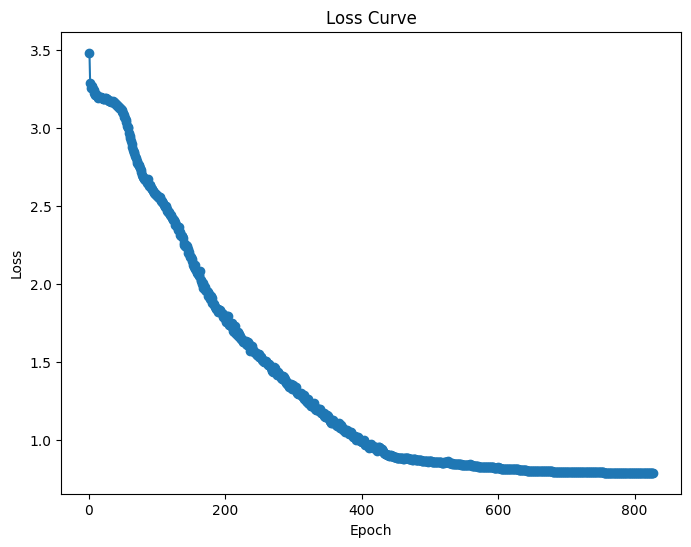

In [17]:
classifier = Classifier(events_df)

model = classifier.train()
classifier.plot_loss_curve()

Accuracy: 0.5517241379310345
Confusion matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0

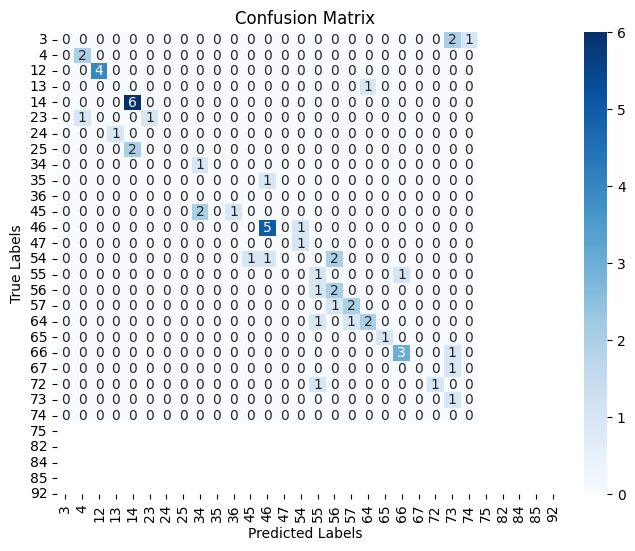

In [18]:
classifier.test()
classifier.confusion_matrix()

In [19]:
# use pymoo and nsga2 to find optimal threshold values

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

termination = get_termination("n_gen", 40)

problem = Classifier(events_df)
problem.train()

# res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)

# X = res.X
# F = res.F


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



MLPClassifier(activation='logistic', hidden_layer_sizes=(400, 100),
              learning_rate='adaptive', learning_rate_init=0.1, max_iter=2500,
              random_state=42, solver='sgd')